# GRU Implementation

In [187]:
# --- we are doing GRU neural network ---
import torch                # pytorch
import torch.nn as nn       # neural network
import torch.optim as optim # optimizer
from torch.utils.data import DataLoader
# progress bars
from tqdm import tqdm
# summary
from torchinfo import summary
# --- end of imports ---

In [188]:
# cuda or mps or cpu for acceleration
if torch.cuda.is_available():
    device = torch.device("cuda") # nvidia gpu
elif torch.backends.mps.is_available(): 
    device = torch.device("mps") # apple silicon
else:                                 
    device = torch.device("cpu") # cpu

print("Device: ", device)

Device:  mps


In [189]:
# split data into training and testing
def train_vali_test_split(data, labels, train=0.8, vali=0.1, test=0.1):
    assert train + vali + test == 1, "train, vali, test must sum to 1"
    total = len(data)

    indices = torch.randperm(total)
    train_end = int(total * train)
    vali_end = int(total * (train + vali))

    train_indices = indices[:train_end]
    vali_indices = indices[train_end:vali_end]
    test_indices = indices[vali_end:]

    train_data = data[train_indices]
    train_labels = labels[train_indices]
    vali_data = data[vali_indices]
    vali_labels = labels[vali_indices]

    test_data = data[test_indices]
    test_labels = labels[test_indices]

    print("Training data: ", len(train_data))
    print("Validation data: ", len(vali_data))
    print("Testing data: ", len(test_data))

    return train_data, train_labels, vali_data, vali_labels, test_data, test_labels

In [210]:
class GRUNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(GRUNet, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        # initialize hidden state
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        print(x.size())
        print(h0.size())

        # if x.dim() == 2:
        #     x = x.unsqueeze(0)
        # forward
        out, _ = self.gru(x, h0)

        # decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        return out

In [191]:
# class LSTMNet(nn.Module): # this may need to be changed and more steps for data loading
#     def __init__(self, input_size, hidden_size, num_layers, output_size):
#         super(LSTMNet, self).__init__()
#         self.hidden_size = hidden_size
#         self.num_layers = num_layers
#         self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
#         self.fc = nn.Linear(hidden_size, output_size)
    
#     def forward(self, x):
#         # initialize hidden state
#         h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
#         c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
#         # forward
#         out, _ = self.lstm(x, (h0, c0))

#         # decode the hidden state of the last time step
#         out = self.fc(out[:, -1, :])
#         return out

In [216]:
# data
NUM_EEG_CHANNELS = 64
NUM_JOINT_ANGLES = 6

# array of eeg as data
eeg_data = torch.randn(100, 100, NUM_EEG_CHANNELS).to(device)
# array of joint angles as labels (or velocity)
joint_angles = torch.randn(100, NUM_JOINT_ANGLES).to(device)

# check dimensions
print(eeg_data.dim())
print(joint_angles.dim())

# keep it in correct shape
# eeg_data = eeg_data.unsqueeze(0)
# print(eeg_data.dim())

3
2


In [217]:
input_size = NUM_EEG_CHANNELS # input size - number of eeg channels
hidden_size = 128 # hidden layer size - what we want to learn
output_size = NUM_JOINT_ANGLES # output size - number of joint angles / features
num_layers = 1 # number of layers
batch_size = 16 # batch size

model = GRUNet(input_size, hidden_size, num_layers=num_layers, output_size=output_size)
model.to(device)

print(model)

print(outputs.shape, joint_angles.shape)
print(inputs.shape, eeg_data.shape)

GRUNet(
  (gru): GRU(64, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=6, bias=True)
)
torch.Size([16, 6]) torch.Size([100, 6])
torch.Size([16, 64]) torch.Size([100, 100, 64])


In [212]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss() # mean squared error loss function

## Training Loop

In [218]:
epochs = 20

# if eeg_data.dim() == 2:
#     eeg_data = eeg_data.unsqueeze(0)

train_data, train_labels, vali_data, vali_labels, test_data, test_labels = train_vali_test_split(eeg_data, joint_angles)

# dataloader
train_dataset = torch.utils.data.TensorDataset(train_data, train_labels)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

vali_dataset = torch.utils.data.TensorDataset(vali_data, vali_labels)
vali_loader = DataLoader(dataset=vali_dataset, batch_size=batch_size, shuffle=False)

Training data:  80
Validation data:  10
Testing data:  10


In [219]:
for inputs, labels in train_loader:
    print(f"Inputs shape: {inputs.shape}, Labels shape: {labels.shape}")
    break  # Just print the first batch to check

Inputs shape: torch.Size([16, 100, 64]), Labels shape: torch.Size([16, 6])


In [220]:
train_loss_arr = []
vali_loss_arr = []

for epoch in range(epochs):
    model.train()
    total_train_loss = 0
    total_vali_loss = 0
    num_train_batches = 0
    num_vali_batches = 0

    for i, data in enumerate(tqdm(train_loader)):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        print(f"Inputs shape: {inputs.shape}, Labels shape: {labels.shape}")

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward + backward + optimize
        outputs = model(inputs)
        print(f"Outputs Shape: {outputs.shape}, Labels Shape: {labels.shape}")
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        num_train_batches += 1

    avg_train_loss = total_train_loss / num_train_batches if num_train_batches > 0 else 0
    train_loss_arr.append(avg_train_loss)

    model.eval()
    with torch.no_grad():
        for i, data in enumerate(tqdm(vali_loader)):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            total_vali_loss += loss.item()
            num_vali_batches += 1

    avg_vali_loss = total_vali_loss / num_vali_batches if num_vali_batches > 0 else 0
    vali_loss_arr.append(avg_vali_loss)

    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {avg_train_loss:.4f} - Vali Loss: {avg_vali_loss:.4f}")

  0%|          | 0/5 [00:00<?, ?it/s]

Inputs shape: torch.Size([16, 100, 64]), Labels shape: torch.Size([16, 6])
torch.Size([16, 100, 64])
torch.Size([1, 16, 128])
Outputs Shape: torch.Size([16, 6]), Labels Shape: torch.Size([16, 6])


 60%|██████    | 3/5 [00:00<00:00,  5.97it/s]

Inputs shape: torch.Size([16, 100, 64]), Labels shape: torch.Size([16, 6])
torch.Size([16, 100, 64])
torch.Size([1, 16, 128])
Outputs Shape: torch.Size([16, 6]), Labels Shape: torch.Size([16, 6])
Inputs shape: torch.Size([16, 100, 64]), Labels shape: torch.Size([16, 6])
torch.Size([16, 100, 64])
torch.Size([1, 16, 128])
Outputs Shape: torch.Size([16, 6]), Labels Shape: torch.Size([16, 6])
Inputs shape: torch.Size([16, 100, 64]), Labels shape: torch.Size([16, 6])
torch.Size([16, 100, 64])
torch.Size([1, 16, 128])
Outputs Shape: torch.Size([16, 6]), Labels Shape: torch.Size([16, 6])


100%|██████████| 5/5 [00:00<00:00,  6.85it/s]


Inputs shape: torch.Size([16, 100, 64]), Labels shape: torch.Size([16, 6])
torch.Size([16, 100, 64])
torch.Size([1, 16, 128])
Outputs Shape: torch.Size([16, 6]), Labels Shape: torch.Size([16, 6])


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([10, 100, 64])
torch.Size([1, 10, 128])


100%|██████████| 1/1 [00:00<00:00,  1.88it/s]


Epoch 1/20 - Train Loss: 1.0300 - Vali Loss: 1.0664


 40%|████      | 2/5 [00:00<00:00, 13.70it/s]

Inputs shape: torch.Size([16, 100, 64]), Labels shape: torch.Size([16, 6])
torch.Size([16, 100, 64])
torch.Size([1, 16, 128])
Outputs Shape: torch.Size([16, 6]), Labels Shape: torch.Size([16, 6])
Inputs shape: torch.Size([16, 100, 64]), Labels shape: torch.Size([16, 6])
torch.Size([16, 100, 64])
torch.Size([1, 16, 128])
Outputs Shape: torch.Size([16, 6]), Labels Shape: torch.Size([16, 6])
Inputs shape: torch.Size([16, 100, 64]), Labels shape: torch.Size([16, 6])
torch.Size([16, 100, 64])
torch.Size([1, 16, 128])
Outputs Shape: torch.Size([16, 6]), Labels Shape: torch.Size([16, 6])


100%|██████████| 5/5 [00:00<00:00, 13.49it/s]


Inputs shape: torch.Size([16, 100, 64]), Labels shape: torch.Size([16, 6])
torch.Size([16, 100, 64])
torch.Size([1, 16, 128])
Outputs Shape: torch.Size([16, 6]), Labels Shape: torch.Size([16, 6])
Inputs shape: torch.Size([16, 100, 64]), Labels shape: torch.Size([16, 6])
torch.Size([16, 100, 64])
torch.Size([1, 16, 128])
Outputs Shape: torch.Size([16, 6]), Labels Shape: torch.Size([16, 6])


100%|██████████| 1/1 [00:00<00:00, 36.37it/s]


torch.Size([10, 100, 64])
torch.Size([1, 10, 128])
Epoch 2/20 - Train Loss: 1.0300 - Vali Loss: 1.0664


  0%|          | 0/5 [00:00<?, ?it/s]

Inputs shape: torch.Size([16, 100, 64]), Labels shape: torch.Size([16, 6])
torch.Size([16, 100, 64])
torch.Size([1, 16, 128])


 40%|████      | 2/5 [00:00<00:00, 13.79it/s]

Outputs Shape: torch.Size([16, 6]), Labels Shape: torch.Size([16, 6])
Inputs shape: torch.Size([16, 100, 64]), Labels shape: torch.Size([16, 6])
torch.Size([16, 100, 64])
torch.Size([1, 16, 128])
Outputs Shape: torch.Size([16, 6]), Labels Shape: torch.Size([16, 6])
Inputs shape: torch.Size([16, 100, 64]), Labels shape: torch.Size([16, 6])
torch.Size([16, 100, 64])
torch.Size([1, 16, 128])
Outputs Shape: torch.Size([16, 6]), Labels Shape: torch.Size([16, 6])
Inputs shape: torch.Size([16, 100, 64]), Labels shape: torch.Size([16, 6])
torch.Size([16, 100, 64])
torch.Size([1, 16, 128])


100%|██████████| 5/5 [00:00<00:00, 13.65it/s]


Outputs Shape: torch.Size([16, 6]), Labels Shape: torch.Size([16, 6])
Inputs shape: torch.Size([16, 100, 64]), Labels shape: torch.Size([16, 6])
torch.Size([16, 100, 64])
torch.Size([1, 16, 128])
Outputs Shape: torch.Size([16, 6]), Labels Shape: torch.Size([16, 6])


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([10, 100, 64])
torch.Size([1, 10, 128])


100%|██████████| 1/1 [00:00<00:00, 36.07it/s]


Epoch 3/20 - Train Loss: 1.0300 - Vali Loss: 1.0664


  0%|          | 0/5 [00:00<?, ?it/s]

Inputs shape: torch.Size([16, 100, 64]), Labels shape: torch.Size([16, 6])
torch.Size([16, 100, 64])
torch.Size([1, 16, 128])
Outputs Shape: torch.Size([16, 6]), Labels Shape: torch.Size([16, 6])


 40%|████      | 2/5 [00:00<00:00, 13.44it/s]

Inputs shape: torch.Size([16, 100, 64]), Labels shape: torch.Size([16, 6])
torch.Size([16, 100, 64])
torch.Size([1, 16, 128])
Outputs Shape: torch.Size([16, 6]), Labels Shape: torch.Size([16, 6])
Inputs shape: torch.Size([16, 100, 64]), Labels shape: torch.Size([16, 6])
torch.Size([16, 100, 64])
torch.Size([1, 16, 128])
Outputs Shape: torch.Size([16, 6]), Labels Shape: torch.Size([16, 6])
Inputs shape: torch.Size([16, 100, 64]), Labels shape: torch.Size([16, 6])
torch.Size([16, 100, 64])
torch.Size([1, 16, 128])
Outputs Shape: torch.Size([16, 6]), Labels Shape: torch.Size([16, 6])


100%|██████████| 5/5 [00:00<00:00, 13.16it/s]

Inputs shape: torch.Size([16, 100, 64]), Labels shape: torch.Size([16, 6])
torch.Size([16, 100, 64])
torch.Size([1, 16, 128])
Outputs Shape: torch.Size([16, 6]), Labels Shape: torch.Size([16, 6])



100%|██████████| 1/1 [00:00<00:00, 36.57it/s]


torch.Size([10, 100, 64])
torch.Size([1, 10, 128])
Epoch 4/20 - Train Loss: 1.0300 - Vali Loss: 1.0664


  0%|          | 0/5 [00:00<?, ?it/s]

Inputs shape: torch.Size([16, 100, 64]), Labels shape: torch.Size([16, 6])
torch.Size([16, 100, 64])
torch.Size([1, 16, 128])
Outputs Shape: torch.Size([16, 6]), Labels Shape: torch.Size([16, 6])
Inputs shape: torch.Size([16, 100, 64]), Labels shape: torch.Size([16, 6])
torch.Size([16, 100, 64])
torch.Size([1, 16, 128])


 40%|████      | 2/5 [00:00<00:00, 13.47it/s]

Outputs Shape: torch.Size([16, 6]), Labels Shape: torch.Size([16, 6])
Inputs shape: torch.Size([16, 100, 64]), Labels shape: torch.Size([16, 6])
torch.Size([16, 100, 64])
torch.Size([1, 16, 128])
Outputs Shape: torch.Size([16, 6]), Labels Shape: torch.Size([16, 6])
Inputs shape: torch.Size([16, 100, 64]), Labels shape: torch.Size([16, 6])
torch.Size([16, 100, 64])
torch.Size([1, 16, 128])
Outputs Shape: torch.Size([16, 6]), Labels Shape: torch.Size([16, 6])


 80%|████████  | 4/5 [00:00<00:00, 13.59it/s]

Inputs shape: torch.Size([16, 100, 64]), Labels shape: torch.Size([16, 6])
torch.Size([16, 100, 64])
torch.Size([1, 16, 128])


100%|██████████| 5/5 [00:00<00:00, 13.58it/s]


Outputs Shape: torch.Size([16, 6]), Labels Shape: torch.Size([16, 6])


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([10, 100, 64])
torch.Size([1, 10, 128])


100%|██████████| 1/1 [00:00<00:00, 34.91it/s]


Epoch 5/20 - Train Loss: 1.0300 - Vali Loss: 1.0664


  0%|          | 0/5 [00:00<?, ?it/s]

Inputs shape: torch.Size([16, 100, 64]), Labels shape: torch.Size([16, 6])
torch.Size([16, 100, 64])
torch.Size([1, 16, 128])
Outputs Shape: torch.Size([16, 6]), Labels Shape: torch.Size([16, 6])
Inputs shape: torch.Size([16, 100, 64]), Labels shape: torch.Size([16, 6])
torch.Size([16, 100, 64])
torch.Size([1, 16, 128])
Outputs Shape: torch.Size([16, 6]), Labels Shape: torch.Size([16, 6])


 40%|████      | 2/5 [00:00<00:00, 13.61it/s]

Inputs shape: torch.Size([16, 100, 64]), Labels shape: torch.Size([16, 6])
torch.Size([16, 100, 64])
torch.Size([1, 16, 128])
Outputs Shape: torch.Size([16, 6]), Labels Shape: torch.Size([16, 6])
Inputs shape: torch.Size([16, 100, 64]), Labels shape: torch.Size([16, 6])
torch.Size([16, 100, 64])
torch.Size([1, 16, 128])
Outputs Shape: torch.Size([16, 6]), Labels Shape: torch.Size([16, 6])


 80%|████████  | 4/5 [00:00<00:00, 13.43it/s]

Inputs shape: torch.Size([16, 100, 64]), Labels shape: torch.Size([16, 6])
torch.Size([16, 100, 64])
torch.Size([1, 16, 128])
Outputs Shape: torch.Size([16, 6]), Labels Shape: torch.Size([16, 6])


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([10, 100, 64])
torch.Size([1, 10, 128])


100%|██████████| 1/1 [00:00<00:00, 35.72it/s]


Epoch 6/20 - Train Loss: 1.0300 - Vali Loss: 1.0664


  0%|          | 0/5 [00:00<?, ?it/s]

Inputs shape: torch.Size([16, 100, 64]), Labels shape: torch.Size([16, 6])
torch.Size([16, 100, 64])
torch.Size([1, 16, 128])
Outputs Shape: torch.Size([16, 6]), Labels Shape: torch.Size([16, 6])
Inputs shape: torch.Size([16, 100, 64]), Labels shape: torch.Size([16, 6])
torch.Size([16, 100, 64])
torch.Size([1, 16, 128])
Outputs Shape: torch.Size([16, 6]), Labels Shape: torch.Size([16, 6])


 40%|████      | 2/5 [00:00<00:00, 13.24it/s]

Inputs shape: torch.Size([16, 100, 64]), Labels shape: torch.Size([16, 6])
torch.Size([16, 100, 64])
torch.Size([1, 16, 128])
Outputs Shape: torch.Size([16, 6]), Labels Shape: torch.Size([16, 6])
Inputs shape: torch.Size([16, 100, 64]), Labels shape: torch.Size([16, 6])
torch.Size([16, 100, 64])
torch.Size([1, 16, 128])
Outputs Shape: torch.Size([16, 6]), Labels Shape: torch.Size([16, 6])


 80%|████████  | 4/5 [00:00<00:00, 13.25it/s]

Inputs shape: torch.Size([16, 100, 64]), Labels shape: torch.Size([16, 6])
torch.Size([16, 100, 64])
torch.Size([1, 16, 128])
Outputs Shape: torch.Size([16, 6]), Labels Shape: torch.Size([16, 6])


100%|██████████| 1/1 [00:00<00:00, 35.82it/s]


torch.Size([10, 100, 64])
torch.Size([1, 10, 128])
Epoch 7/20 - Train Loss: 1.0300 - Vali Loss: 1.0664


  0%|          | 0/5 [00:00<?, ?it/s]

Inputs shape: torch.Size([16, 100, 64]), Labels shape: torch.Size([16, 6])
torch.Size([16, 100, 64])
torch.Size([1, 16, 128])
Outputs Shape: torch.Size([16, 6]), Labels Shape: torch.Size([16, 6])
Inputs shape: torch.Size([16, 100, 64]), Labels shape: torch.Size([16, 6])
torch.Size([16, 100, 64])
torch.Size([1, 16, 128])
Outputs Shape: torch.Size([16, 6]), Labels Shape: torch.Size([16, 6])


 40%|████      | 2/5 [00:00<00:00, 13.39it/s]

Inputs shape: torch.Size([16, 100, 64]), Labels shape: torch.Size([16, 6])
torch.Size([16, 100, 64])
torch.Size([1, 16, 128])
Outputs Shape: torch.Size([16, 6]), Labels Shape: torch.Size([16, 6])
Inputs shape: torch.Size([16, 100, 64]), Labels shape: torch.Size([16, 6])
torch.Size([16, 100, 64])
torch.Size([1, 16, 128])
Outputs Shape: torch.Size([16, 6]), Labels Shape: torch.Size([16, 6])


 80%|████████  | 4/5 [00:00<00:00, 13.25it/s]

Inputs shape: torch.Size([16, 100, 64]), Labels shape: torch.Size([16, 6])
torch.Size([16, 100, 64])
torch.Size([1, 16, 128])
Outputs Shape: torch.Size([16, 6]), Labels Shape: torch.Size([16, 6])


100%|██████████| 1/1 [00:00<00:00, 33.88it/s]


torch.Size([10, 100, 64])
torch.Size([1, 10, 128])
Epoch 8/20 - Train Loss: 1.0300 - Vali Loss: 1.0664


  0%|          | 0/5 [00:00<?, ?it/s]

Inputs shape: torch.Size([16, 100, 64]), Labels shape: torch.Size([16, 6])
torch.Size([16, 100, 64])
torch.Size([1, 16, 128])
Outputs Shape: torch.Size([16, 6]), Labels Shape: torch.Size([16, 6])
Inputs shape: torch.Size([16, 100, 64]), Labels shape: torch.Size([16, 6])
torch.Size([16, 100, 64])
torch.Size([1, 16, 128])
Outputs Shape: torch.Size([16, 6]), Labels Shape: torch.Size([16, 6])


 40%|████      | 2/5 [00:00<00:00, 13.02it/s]

Inputs shape: torch.Size([16, 100, 64]), Labels shape: torch.Size([16, 6])
torch.Size([16, 100, 64])
torch.Size([1, 16, 128])
Outputs Shape: torch.Size([16, 6]), Labels Shape: torch.Size([16, 6])
Inputs shape: torch.Size([16, 100, 64]), Labels shape: torch.Size([16, 6])
torch.Size([16, 100, 64])
torch.Size([1, 16, 128])
Outputs Shape: torch.Size([16, 6]), Labels Shape: torch.Size([16, 6])


 80%|████████  | 4/5 [00:00<00:00, 12.93it/s]

Inputs shape: torch.Size([16, 100, 64]), Labels shape: torch.Size([16, 6])
torch.Size([16, 100, 64])
torch.Size([1, 16, 128])
Outputs Shape: torch.Size([16, 6]), Labels Shape: torch.Size([16, 6])


100%|██████████| 1/1 [00:00<00:00, 33.15it/s]


torch.Size([10, 100, 64])
torch.Size([1, 10, 128])
Epoch 9/20 - Train Loss: 1.0300 - Vali Loss: 1.0664


  0%|          | 0/5 [00:00<?, ?it/s]

Inputs shape: torch.Size([16, 100, 64]), Labels shape: torch.Size([16, 6])
torch.Size([16, 100, 64])
torch.Size([1, 16, 128])
Outputs Shape: torch.Size([16, 6]), Labels Shape: torch.Size([16, 6])
Inputs shape: torch.Size([16, 100, 64]), Labels shape: torch.Size([16, 6])
torch.Size([16, 100, 64])
torch.Size([1, 16, 128])


 40%|████      | 2/5 [00:00<00:00, 13.00it/s]

Outputs Shape: torch.Size([16, 6]), Labels Shape: torch.Size([16, 6])
Inputs shape: torch.Size([16, 100, 64]), Labels shape: torch.Size([16, 6])
torch.Size([16, 100, 64])
torch.Size([1, 16, 128])
Outputs Shape: torch.Size([16, 6]), Labels Shape: torch.Size([16, 6])


 80%|████████  | 4/5 [00:00<00:00, 13.06it/s]

Inputs shape: torch.Size([16, 100, 64]), Labels shape: torch.Size([16, 6])
torch.Size([16, 100, 64])
torch.Size([1, 16, 128])
Outputs Shape: torch.Size([16, 6]), Labels Shape: torch.Size([16, 6])
Inputs shape: torch.Size([16, 100, 64]), Labels shape: torch.Size([16, 6])
torch.Size([16, 100, 64])
torch.Size([1, 16, 128])


100%|██████████| 5/5 [00:00<00:00, 13.11it/s]


Outputs Shape: torch.Size([16, 6]), Labels Shape: torch.Size([16, 6])


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([10, 100, 64])
torch.Size([1, 10, 128])


100%|██████████| 1/1 [00:00<00:00, 35.74it/s]


Epoch 10/20 - Train Loss: 1.0300 - Vali Loss: 1.0664


  0%|          | 0/5 [00:00<?, ?it/s]

Inputs shape: torch.Size([16, 100, 64]), Labels shape: torch.Size([16, 6])
torch.Size([16, 100, 64])
torch.Size([1, 16, 128])
Outputs Shape: torch.Size([16, 6]), Labels Shape: torch.Size([16, 6])
Inputs shape: torch.Size([16, 100, 64]), Labels shape: torch.Size([16, 6])
torch.Size([16, 100, 64])
torch.Size([1, 16, 128])
Outputs Shape: torch.Size([16, 6]), Labels Shape: torch.Size([16, 6])


 40%|████      | 2/5 [00:00<00:00, 13.67it/s]

Inputs shape: torch.Size([16, 100, 64]), Labels shape: torch.Size([16, 6])
torch.Size([16, 100, 64])
torch.Size([1, 16, 128])
Outputs Shape: torch.Size([16, 6]), Labels Shape: torch.Size([16, 6])
Inputs shape: torch.Size([16, 100, 64]), Labels shape: torch.Size([16, 6])
torch.Size([16, 100, 64])
torch.Size([1, 16, 128])


 80%|████████  | 4/5 [00:00<00:00, 13.38it/s]

Outputs Shape: torch.Size([16, 6]), Labels Shape: torch.Size([16, 6])
Inputs shape: torch.Size([16, 100, 64]), Labels shape: torch.Size([16, 6])
torch.Size([16, 100, 64])
torch.Size([1, 16, 128])
Outputs Shape: torch.Size([16, 6]), Labels Shape: torch.Size([16, 6])


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([10, 100, 64])
torch.Size([1, 10, 128])


100%|██████████| 1/1 [00:00<00:00, 34.37it/s]


Epoch 11/20 - Train Loss: 1.0300 - Vali Loss: 1.0664


  0%|          | 0/5 [00:00<?, ?it/s]

Inputs shape: torch.Size([16, 100, 64]), Labels shape: torch.Size([16, 6])
torch.Size([16, 100, 64])
torch.Size([1, 16, 128])
Outputs Shape: torch.Size([16, 6]), Labels Shape: torch.Size([16, 6])


 40%|████      | 2/5 [00:00<00:00, 13.37it/s]

Inputs shape: torch.Size([16, 100, 64]), Labels shape: torch.Size([16, 6])
torch.Size([16, 100, 64])
torch.Size([1, 16, 128])
Outputs Shape: torch.Size([16, 6]), Labels Shape: torch.Size([16, 6])
Inputs shape: torch.Size([16, 100, 64]), Labels shape: torch.Size([16, 6])
torch.Size([16, 100, 64])
torch.Size([1, 16, 128])
Outputs Shape: torch.Size([16, 6]), Labels Shape: torch.Size([16, 6])
Inputs shape: torch.Size([16, 100, 64]), Labels shape: torch.Size([16, 6])
torch.Size([16, 100, 64])
torch.Size([1, 16, 128])
Outputs Shape: torch.Size([16, 6]), Labels Shape: torch.Size([16, 6])


 80%|████████  | 4/5 [00:00<00:00, 13.22it/s]

Inputs shape: torch.Size([16, 100, 64]), Labels shape: torch.Size([16, 6])
torch.Size([16, 100, 64])
torch.Size([1, 16, 128])
Outputs Shape: torch.Size([16, 6]), Labels Shape: torch.Size([16, 6])


100%|██████████| 1/1 [00:00<00:00, 34.88it/s]


torch.Size([10, 100, 64])
torch.Size([1, 10, 128])
Epoch 12/20 - Train Loss: 1.0300 - Vali Loss: 1.0664


  0%|          | 0/5 [00:00<?, ?it/s]

Inputs shape: torch.Size([16, 100, 64]), Labels shape: torch.Size([16, 6])
torch.Size([16, 100, 64])
torch.Size([1, 16, 128])
Outputs Shape: torch.Size([16, 6]), Labels Shape: torch.Size([16, 6])
Inputs shape: torch.Size([16, 100, 64]), Labels shape: torch.Size([16, 6])
torch.Size([16, 100, 64])
torch.Size([1, 16, 128])


 40%|████      | 2/5 [00:00<00:00, 12.36it/s]

Outputs Shape: torch.Size([16, 6]), Labels Shape: torch.Size([16, 6])
Inputs shape: torch.Size([16, 100, 64]), Labels shape: torch.Size([16, 6])
torch.Size([16, 100, 64])
torch.Size([1, 16, 128])
Outputs Shape: torch.Size([16, 6]), Labels Shape: torch.Size([16, 6])
Inputs shape: torch.Size([16, 100, 64]), Labels shape: torch.Size([16, 6])
torch.Size([16, 100, 64])
torch.Size([1, 16, 128])
Outputs Shape: torch.Size([16, 6]), Labels Shape: torch.Size([16, 6])


 80%|████████  | 4/5 [00:00<00:00, 12.62it/s]

Inputs shape: torch.Size([16, 100, 64]), Labels shape: torch.Size([16, 6])
torch.Size([16, 100, 64])
torch.Size([1, 16, 128])
Outputs Shape: torch.Size([16, 6]), Labels Shape: torch.Size([16, 6])


100%|██████████| 1/1 [00:00<00:00, 35.49it/s]


torch.Size([10, 100, 64])
torch.Size([1, 10, 128])
Epoch 13/20 - Train Loss: 1.0300 - Vali Loss: 1.0664


  0%|          | 0/5 [00:00<?, ?it/s]

Inputs shape: torch.Size([16, 100, 64]), Labels shape: torch.Size([16, 6])
torch.Size([16, 100, 64])
torch.Size([1, 16, 128])
Outputs Shape: torch.Size([16, 6]), Labels Shape: torch.Size([16, 6])
Inputs shape: torch.Size([16, 100, 64]), Labels shape: torch.Size([16, 6])
torch.Size([16, 100, 64])
torch.Size([1, 16, 128])


 40%|████      | 2/5 [00:00<00:00, 13.15it/s]

Outputs Shape: torch.Size([16, 6]), Labels Shape: torch.Size([16, 6])
Inputs shape: torch.Size([16, 100, 64]), Labels shape: torch.Size([16, 6])
torch.Size([16, 100, 64])
torch.Size([1, 16, 128])
Outputs Shape: torch.Size([16, 6]), Labels Shape: torch.Size([16, 6])
Inputs shape: torch.Size([16, 100, 64]), Labels shape: torch.Size([16, 6])
torch.Size([16, 100, 64])
torch.Size([1, 16, 128])


 80%|████████  | 4/5 [00:00<00:00, 13.07it/s]

Outputs Shape: torch.Size([16, 6]), Labels Shape: torch.Size([16, 6])
Inputs shape: torch.Size([16, 100, 64]), Labels shape: torch.Size([16, 6])
torch.Size([16, 100, 64])
torch.Size([1, 16, 128])
Outputs Shape: torch.Size([16, 6]), Labels Shape: torch.Size([16, 6])


100%|██████████| 1/1 [00:00<00:00, 35.44it/s]


torch.Size([10, 100, 64])
torch.Size([1, 10, 128])
Epoch 14/20 - Train Loss: 1.0300 - Vali Loss: 1.0664


  0%|          | 0/5 [00:00<?, ?it/s]

Inputs shape: torch.Size([16, 100, 64]), Labels shape: torch.Size([16, 6])
torch.Size([16, 100, 64])
torch.Size([1, 16, 128])
Outputs Shape: torch.Size([16, 6]), Labels Shape: torch.Size([16, 6])
Inputs shape: torch.Size([16, 100, 64]), Labels shape: torch.Size([16, 6])
torch.Size([16, 100, 64])
torch.Size([1, 16, 128])
Outputs Shape: torch.Size([16, 6]), Labels Shape: torch.Size([16, 6])


 40%|████      | 2/5 [00:00<00:00, 13.26it/s]

Inputs shape: torch.Size([16, 100, 64]), Labels shape: torch.Size([16, 6])
torch.Size([16, 100, 64])
torch.Size([1, 16, 128])
Outputs Shape: torch.Size([16, 6]), Labels Shape: torch.Size([16, 6])
Inputs shape: torch.Size([16, 100, 64]), Labels shape: torch.Size([16, 6])
torch.Size([16, 100, 64])
torch.Size([1, 16, 128])
Outputs Shape: torch.Size([16, 6]), Labels Shape: torch.Size([16, 6])


 80%|████████  | 4/5 [00:00<00:00, 13.03it/s]

Inputs shape: torch.Size([16, 100, 64]), Labels shape: torch.Size([16, 6])
torch.Size([16, 100, 64])
torch.Size([1, 16, 128])
Outputs Shape: torch.Size([16, 6]), Labels Shape: torch.Size([16, 6])


100%|██████████| 1/1 [00:00<00:00, 34.34it/s]


torch.Size([10, 100, 64])
torch.Size([1, 10, 128])
Epoch 15/20 - Train Loss: 1.0300 - Vali Loss: 1.0664


  0%|          | 0/5 [00:00<?, ?it/s]

Inputs shape: torch.Size([16, 100, 64]), Labels shape: torch.Size([16, 6])
torch.Size([16, 100, 64])
torch.Size([1, 16, 128])
Outputs Shape: torch.Size([16, 6]), Labels Shape: torch.Size([16, 6])
Inputs shape: torch.Size([16, 100, 64]), Labels shape: torch.Size([16, 6])
torch.Size([16, 100, 64])
torch.Size([1, 16, 128])


 40%|████      | 2/5 [00:00<00:00, 13.02it/s]

Outputs Shape: torch.Size([16, 6]), Labels Shape: torch.Size([16, 6])
Inputs shape: torch.Size([16, 100, 64]), Labels shape: torch.Size([16, 6])
torch.Size([16, 100, 64])
torch.Size([1, 16, 128])
Outputs Shape: torch.Size([16, 6]), Labels Shape: torch.Size([16, 6])
Inputs shape: torch.Size([16, 100, 64]), Labels shape: torch.Size([16, 6])
torch.Size([16, 100, 64])
torch.Size([1, 16, 128])
Outputs Shape: torch.Size([16, 6]), Labels Shape: torch.Size([16, 6])


 80%|████████  | 4/5 [00:00<00:00, 13.09it/s]

Inputs shape: torch.Size([16, 100, 64]), Labels shape: torch.Size([16, 6])
torch.Size([16, 100, 64])
torch.Size([1, 16, 128])


100%|██████████| 5/5 [00:00<00:00, 13.05it/s]


Outputs Shape: torch.Size([16, 6]), Labels Shape: torch.Size([16, 6])


100%|██████████| 1/1 [00:00<00:00, 35.62it/s]


torch.Size([10, 100, 64])
torch.Size([1, 10, 128])
Epoch 16/20 - Train Loss: 1.0300 - Vali Loss: 1.0664


  0%|          | 0/5 [00:00<?, ?it/s]

Inputs shape: torch.Size([16, 100, 64]), Labels shape: torch.Size([16, 6])
torch.Size([16, 100, 64])
torch.Size([1, 16, 128])
Outputs Shape: torch.Size([16, 6]), Labels Shape: torch.Size([16, 6])
Inputs shape: torch.Size([16, 100, 64]), Labels shape: torch.Size([16, 6])
torch.Size([16, 100, 64])
torch.Size([1, 16, 128])
Outputs Shape: torch.Size([16, 6]), Labels Shape: torch.Size([16, 6])


 40%|████      | 2/5 [00:00<00:00, 13.23it/s]

Inputs shape: torch.Size([16, 100, 64]), Labels shape: torch.Size([16, 6])
torch.Size([16, 100, 64])
torch.Size([1, 16, 128])
Outputs Shape: torch.Size([16, 6]), Labels Shape: torch.Size([16, 6])
Inputs shape: torch.Size([16, 100, 64]), Labels shape: torch.Size([16, 6])
torch.Size([16, 100, 64])
torch.Size([1, 16, 128])
Outputs Shape: torch.Size([16, 6]), Labels Shape: torch.Size([16, 6])


 80%|████████  | 4/5 [00:00<00:00, 13.33it/s]

Inputs shape: torch.Size([16, 100, 64]), Labels shape: torch.Size([16, 6])
torch.Size([16, 100, 64])
torch.Size([1, 16, 128])
Outputs Shape: torch.Size([16, 6]), Labels Shape: torch.Size([16, 6])


  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([10, 100, 64])
torch.Size([1, 10, 128])


100%|██████████| 1/1 [00:00<00:00, 34.70it/s]


Epoch 17/20 - Train Loss: 1.0300 - Vali Loss: 1.0664


  0%|          | 0/5 [00:00<?, ?it/s]

Inputs shape: torch.Size([16, 100, 64]), Labels shape: torch.Size([16, 6])
torch.Size([16, 100, 64])
torch.Size([1, 16, 128])
Outputs Shape: torch.Size([16, 6]), Labels Shape: torch.Size([16, 6])
Inputs shape: torch.Size([16, 100, 64]), Labels shape: torch.Size([16, 6])
torch.Size([16, 100, 64])
torch.Size([1, 16, 128])
Outputs Shape: torch.Size([16, 6]), Labels Shape: torch.Size([16, 6])


 40%|████      | 2/5 [00:00<00:00, 13.32it/s]

Inputs shape: torch.Size([16, 100, 64]), Labels shape: torch.Size([16, 6])
torch.Size([16, 100, 64])
torch.Size([1, 16, 128])
Outputs Shape: torch.Size([16, 6]), Labels Shape: torch.Size([16, 6])
Inputs shape: torch.Size([16, 100, 64]), Labels shape: torch.Size([16, 6])
torch.Size([16, 100, 64])
torch.Size([1, 16, 128])
Outputs Shape: torch.Size([16, 6]), Labels Shape: torch.Size([16, 6])


 80%|████████  | 4/5 [00:00<00:00, 13.30it/s]

Inputs shape: torch.Size([16, 100, 64]), Labels shape: torch.Size([16, 6])
torch.Size([16, 100, 64])
torch.Size([1, 16, 128])
Outputs Shape: torch.Size([16, 6]), Labels Shape: torch.Size([16, 6])


100%|██████████| 1/1 [00:00<00:00, 35.08it/s]


torch.Size([10, 100, 64])
torch.Size([1, 10, 128])
Epoch 18/20 - Train Loss: 1.0300 - Vali Loss: 1.0664


  0%|          | 0/5 [00:00<?, ?it/s]

Inputs shape: torch.Size([16, 100, 64]), Labels shape: torch.Size([16, 6])
torch.Size([16, 100, 64])
torch.Size([1, 16, 128])
Outputs Shape: torch.Size([16, 6]), Labels Shape: torch.Size([16, 6])
Inputs shape: torch.Size([16, 100, 64]), Labels shape: torch.Size([16, 6])
torch.Size([16, 100, 64])
torch.Size([1, 16, 128])
Outputs Shape: torch.Size([16, 6]), Labels Shape: torch.Size([16, 6])


 40%|████      | 2/5 [00:00<00:00, 12.96it/s]

Inputs shape: torch.Size([16, 100, 64]), Labels shape: torch.Size([16, 6])
torch.Size([16, 100, 64])
torch.Size([1, 16, 128])
Outputs Shape: torch.Size([16, 6]), Labels Shape: torch.Size([16, 6])
Inputs shape: torch.Size([16, 100, 64]), Labels shape: torch.Size([16, 6])
torch.Size([16, 100, 64])
torch.Size([1, 16, 128])
Outputs Shape: torch.Size([16, 6]), Labels Shape: torch.Size([16, 6])


 80%|████████  | 4/5 [00:00<00:00, 12.90it/s]

Inputs shape: torch.Size([16, 100, 64]), Labels shape: torch.Size([16, 6])
torch.Size([16, 100, 64])
torch.Size([1, 16, 128])
Outputs Shape: torch.Size([16, 6]), Labels Shape: torch.Size([16, 6])


100%|██████████| 1/1 [00:00<00:00, 32.84it/s]


torch.Size([10, 100, 64])
torch.Size([1, 10, 128])
Epoch 19/20 - Train Loss: 1.0300 - Vali Loss: 1.0664


  0%|          | 0/5 [00:00<?, ?it/s]

Inputs shape: torch.Size([16, 100, 64]), Labels shape: torch.Size([16, 6])
torch.Size([16, 100, 64])
torch.Size([1, 16, 128])
Outputs Shape: torch.Size([16, 6]), Labels Shape: torch.Size([16, 6])
Inputs shape: torch.Size([16, 100, 64]), Labels shape: torch.Size([16, 6])
torch.Size([16, 100, 64])
torch.Size([1, 16, 128])


 40%|████      | 2/5 [00:00<00:00, 13.02it/s]

Outputs Shape: torch.Size([16, 6]), Labels Shape: torch.Size([16, 6])
Inputs shape: torch.Size([16, 100, 64]), Labels shape: torch.Size([16, 6])
torch.Size([16, 100, 64])
torch.Size([1, 16, 128])
Outputs Shape: torch.Size([16, 6]), Labels Shape: torch.Size([16, 6])
Inputs shape: torch.Size([16, 100, 64]), Labels shape: torch.Size([16, 6])


 80%|████████  | 4/5 [00:00<00:00, 13.10it/s]

torch.Size([16, 100, 64])
torch.Size([1, 16, 128])
Outputs Shape: torch.Size([16, 6]), Labels Shape: torch.Size([16, 6])
Inputs shape: torch.Size([16, 100, 64]), Labels shape: torch.Size([16, 6])
torch.Size([16, 100, 64])
torch.Size([1, 16, 128])


100%|██████████| 5/5 [00:00<00:00, 13.03it/s]

Outputs Shape: torch.Size([16, 6]), Labels Shape: torch.Size([16, 6])



100%|██████████| 1/1 [00:00<00:00, 34.88it/s]

torch.Size([10, 100, 64])
torch.Size([1, 10, 128])
Epoch 20/20 - Train Loss: 1.0300 - Vali Loss: 1.0664


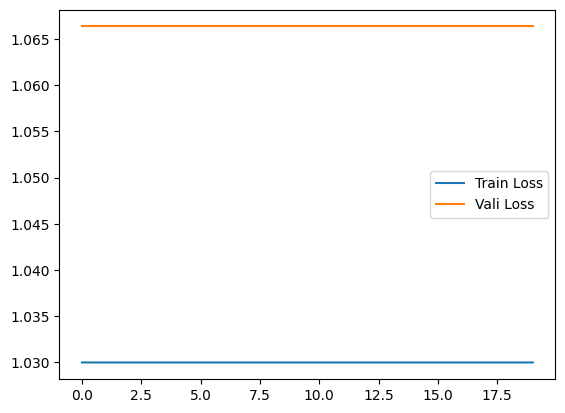

In [221]:
# plot the loss
import matplotlib.pyplot as plt
plt.plot(train_loss_arr, label="Train Loss")
plt.plot(vali_loss_arr, label="Vali Loss")
plt.legend()
plt.show()